In [177]:
### Imports: Key ones -> geopy, pandas, sklearn.cluster, permutations
import csv
import geopy.distance as geo

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

import pandas as pd
from sklearn.cluster import KMeans
# Calculate silhouette_score
from sklearn.metrics import silhouette_score

import sys
import time
import math

from itertools import permutations

In [101]:
### US states mapped to their abbreviations
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
### State names
state_names = us_state_abbrev.values()

In [108]:
# Load in the locations as coordinates, map US state abbrev. to capital Name, (latitude, longitude)
locations = {}
with open('locations.csv') as location:
    location_csv = csv.reader(location, delimiter=',')
    first = True
    for row in location_csv:
        if first:
            first = False
            continue
        state = row[0]
        capital = row[1]
        latitude = float(row[2])
        longitude = -1 * float(row[3])
        locations[us_state_abbrev[state]] = [capital, (latitude, longitude)]

## Add the DC location
locations['DC'] = [None, (38.9072, 77.0369)]

In [103]:
### One thought process was to only consider states that neighbored each other.
borders = {}
with open('borders.csv') as border:
    border_csv = csv.reader(border, delimiter=',')
    first = True
    for row in border_csv:
        if first:
            first = False
            continue
        state1 = row[1]
        state2 = row[2]
        if state1 not in borders:
            borders[state1] = [state2]
        else:
            borders[state1] += [state2]

borders['DC'] = ['MD', 'VA']
borders['MD'] += ['DC']
borders['VA'] += ['DC']

In [117]:
def get_coordinates(location):
    """Get list of labels, list of latitudes (x), and list of longitudes (y)"""
    labels = []
    x = []
    y = []
    for state, capital_loc in location.items():
        labels.append(state)
        x.append(capital_loc[1][1])
        y.append(capital_loc[1][0])
    return [labels, x, y]
        
def dist(state1, state2):
    "Returns the distance between two states, input as state abbreviations (ie. AK)"
    return geo.distance(locations[state1][1], locations[state2][1]).miles

def edge(state, num):
    """Calculate the num^th closest connections"""
    ## Connecting edge cases
    total = []
    for state_comp in list(state_names):
        if state_comp != state:
            total.append((state_comp, dist(state, state_comp)))
    total = sorted(total, key = lambda t:t[1], reverse=False)
    return total[:num]

In [119]:
### Orginal thought process was to ignore HI and AK and find a path along CA -> HI -> OR -> AK -> WA
### We will see later how this is not optimal
print("Two closest for Hawaii", edge('HI', 2))
print("Two closest for Alaska", edge('AK', 2))
print("Four closest for Iowa", edge('IA', 4))

Two closest for Hawaii [('CA', 2461.7061854861327), ('OR', 2561.072478471848)]
Two closest for Alaska [('WA', 914.3040227770455), ('OR', 1042.5522398464848)]
Two closest for Iowa [('NE', 170.15784187613482), ('KS', 206.82739300251137), ('MO', 221.19647263589283), ('MN', 233.60058358525484)]


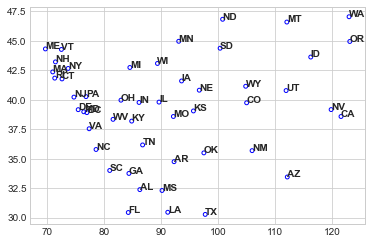

In [154]:
mod_locations = locations.copy() ## Remove Hawaii and Alaska in the location dictionary
mod_locations.pop('HI')
mod_locations.pop('AK')
labels, x, y = get_coordinates(mod_locations) ## Obtain state abbr., latitudes and longitudes

fig, ax = plt.subplots()
ax.scatter(x, y, s=15, facecolors='none', edgecolors='b')

for i, txt in enumerate(labels):
    ax.annotate(txt, (float(x[i]), float(y[i])), weight='bold')

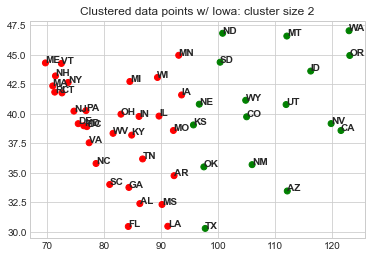

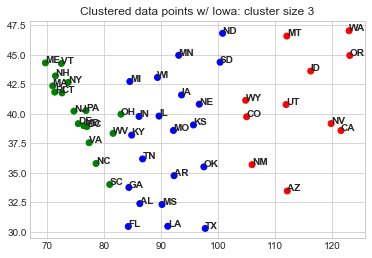

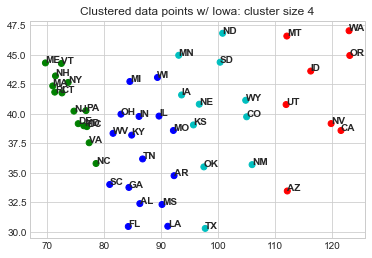

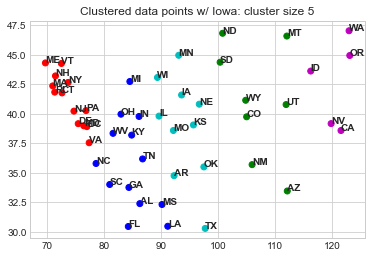

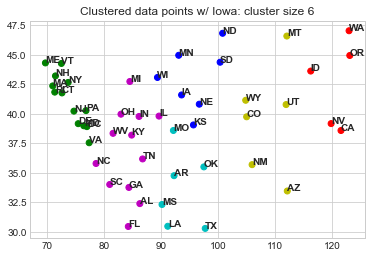

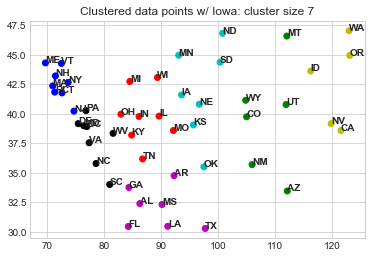

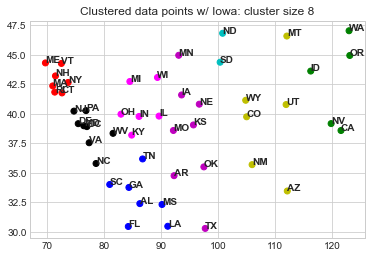

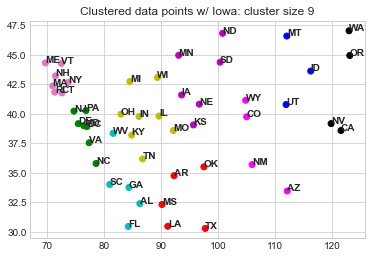

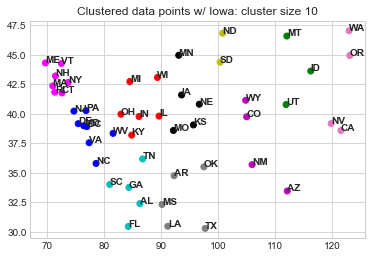

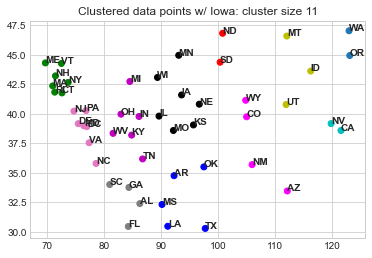

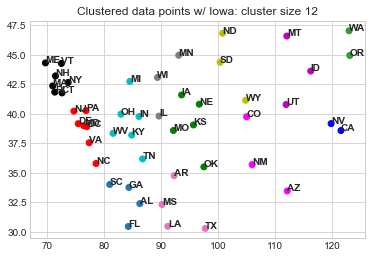

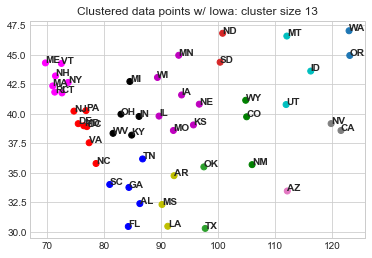

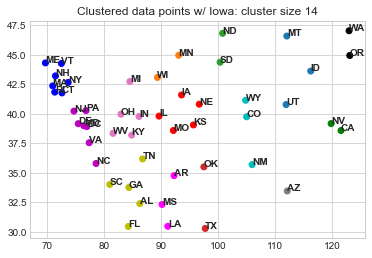

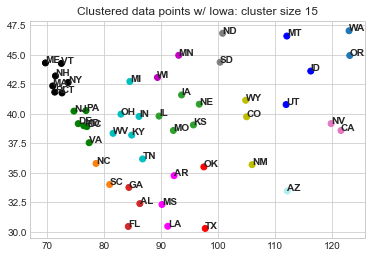

In [160]:
mod_locations = locations.copy() ## Remove Hawaii and Alaska in the location dictionary
mod_locations.pop('HI')
mod_locations.pop('AK')
labels, x, y = get_coordinates(mod_locations) ## Obtain state abbr., latitudes and longitudes

data_np = np.column_stack((x,y)) ## Vertical stack data

colormap = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'k',
                     'magenta', 'tab:pink', 'tab:gray', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange',
                    'paleturquoise', 'indianred', 'peru']) ## Colors for the plot
for idx in range(2, 16): ## Iterate through all cluster sizes
    kmeans = KMeans(n_clusters=idx, random_state=0).fit(data_np) ## Compute kmeans

    cluster = kmeans.labels_.tolist() ## Labelings for the 49 capitals considered

    # Plotting the cluster centers and the data points on a 2D plane
    plt.scatter(data_np[:, 0], data_np[:, -1], c=colormap[cluster])
    for i, txt in enumerate(labels):
        plt.annotate(txt, (float(x[i]), float(y[i])), weight='bold')

    plt.title('Clustered data points w/ Iowa: cluster size ' + str(idx))
    plt.show()

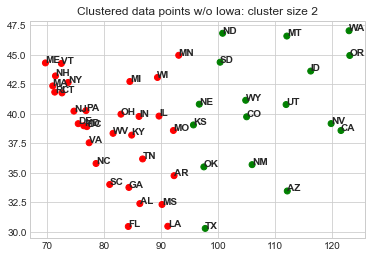

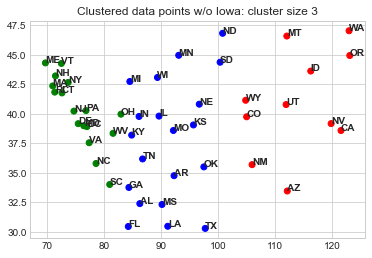

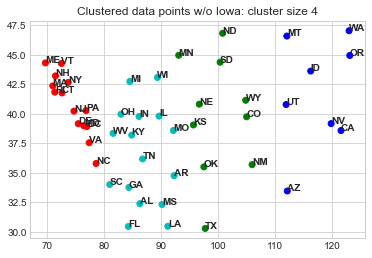

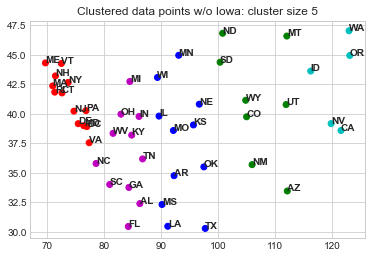

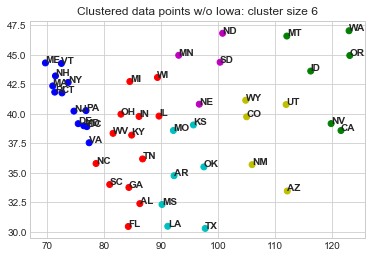

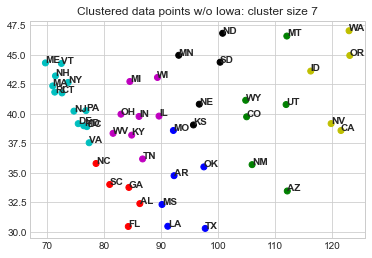

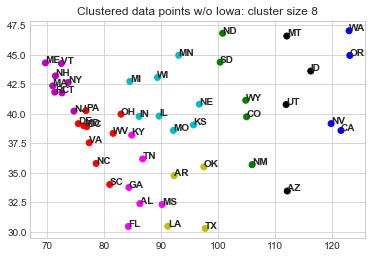

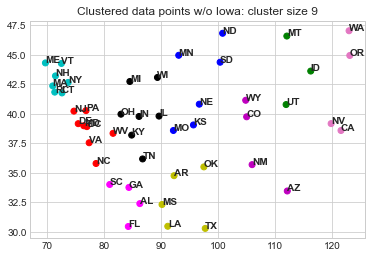

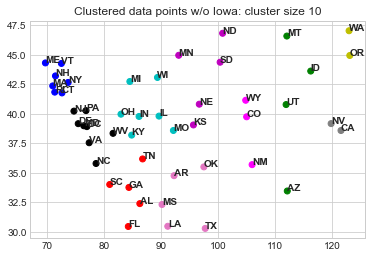

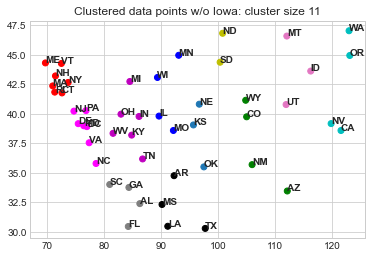

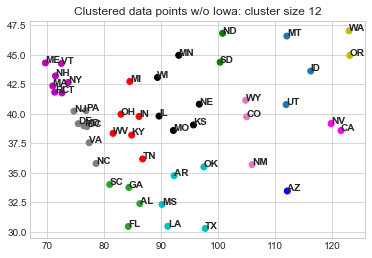

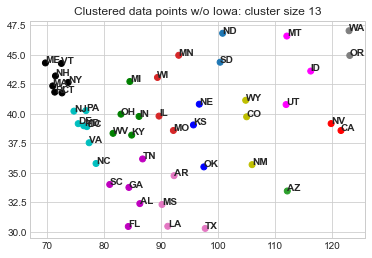

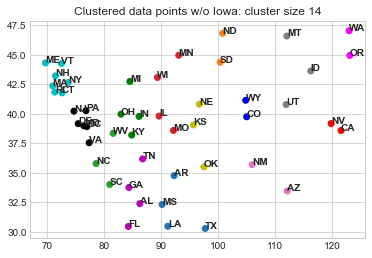

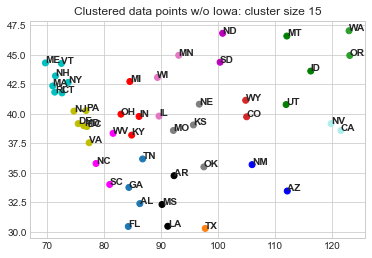

In [161]:
mod_locations = locations.copy() ## Remove Hawaii, Alaska, and Iowa in the location dictionary
mod_locations.pop('HI')
mod_locations.pop('AK')
mod_locations.pop('IA')
labels, x, y = get_coordinates(mod_locations) ## Obtain state abbr., latitudes and longitudes

# Specify the number of clusters (3) and fit the data X
data_np = np.column_stack((x,y))

for idx in range(2, 16):
    kmeans = KMeans(n_clusters=idx, random_state=0).fit(data_np)

    cluster = kmeans.labels_.tolist()

    # Plotting the cluster centers and the data points on a 2D plane
    plt.scatter(data_np[:, 0], data_np[:, -1], c=colormap[cluster])
    for i, txt in enumerate(labels):
        plt.annotate(txt, (float(x[i]), float(y[i])), weight='bold')

    plt.title('Clustered data points w/o Iowa: cluster size ' + str(idx))
    plt.show()

In [340]:
def organizer(labels, cluster, clusterNum):
    """Organizes the 49 capitals into lists of lists where each inner lists represents a cluster"""
    organizer = [0] * clusterNum
    for cat in range(clusterNum):
        store = []
        for i, state in enumerate(labels):
            if cluster[i] == cat:
                store.append(state)
        organizer[cat] = store
    
    return organizer

def calc(organizer, center, clusterNum):
    """Calculates the optimal path between clusters"""
    total = list(range(clusterNum))
    for idx, state_set in enumerate(organizer):
        if 'IA' in state_set:
            start = idx ## Gets the start cluster number with Iowa
        if 'DC' in state_set:
            end = idx ## Gets the end cluster number with DC
    
    order = dist_centers(center, start, end) ## Calculate the order using centers
    
    total_distance = 0
    total_path = ['IA'] ### Start at Iowa
    for idx, index in enumerate(order):
        if index == start: ## Specifics for Iowa cluster
            storage = dist_inner(organizer[index], 'IA', None) ## Start at Iowa no endNode
            state_set1 = list(storage.keys()) ## all end states 
            state_set2 = organizer[order[idx + 1]] ## next clusters states
            min_connect = dist_between(storage, state_set1, state_set2) ## Optimal connection
            total_distance += min_connect[1] ## add the distance
            total_path += (list(storage[min_connect[0][0]][1]) + [min_connect[0][1]]) ## Create path
            next_state = min_connect[0][1] ## Next start state
        elif idx != len(order) - 1:
            storage = dist_inner(organizer[index], next_state, None) ## Start at previous next_state, same process
            state_set1 = list(storage.keys())
            state_set2 = organizer[order[idx + 1]]
            min_connect = dist_between(storage, state_set1, state_set2)
            total_distance += min_connect[1]
            total_path += (list(storage[min_connect[0][0]][1]) + [min_connect[0][1]])
            next_state = min_connect[0][1]
        else:
            storage = dist_inner(organizer[index], next_state, 'DC') ## End at DC
            total_distance += storage[0]
            total_path += (list(storage[1]) + ['DC'])
    
    print(total_path)

def dist_centers(centers, startIDX, endIDX):
    """Calculates the order of clusters using the centroid"""
    centers = [center[::-1] for center in centers] ### Reorders the coordinates
    num_clusters = len(centers)
    
    cluster = {}
    for idx, center in enumerate(centers):
        cluster[tuple(center)] = idx ### Assigns them in a mapping
        
    startNode = centers[startIDX]
    endNode = centers[endIDX]
    centers.remove(endNode) ### Remove end and start clusters
    centers.remove(startNode)
    
    storage = [float("inf"), '']
    for ordering in list(permutations(centers)): ### Permutate over all orderings of clusters (not including the start and end)
        #tracker = []
        distance = geo.distance(startNode, ordering[0]).miles ## Calculates distance between startNode and first element in permuatation
        #tracker.append(([cluster[tuple(startNode)], cluster[tuple(ordering[0])]], distance))
        center_prev = ordering[0]
        for center in ordering[1:]:
            distance += geo.distance(center_prev, center).miles ## Calculates distance of inner elements
            #tracker.append(([cluster[tuple(center_prev)], cluster[tuple(center)]], geo.distance(center_prev, center).miles))
            center_prev = center
        distance += geo.distance(center_prev, endNode).miles ## Calculates distance between last element of permutation and endNode
        #tracker.append(([cluster[tuple(center_prev)], cluster[tuple(endNode)]],geo.distance(center_prev, endNode).miles))
        if storage[0] > distance: ## If the distance is less than any calculated before, we store
            storage = [distance, ordering]
            #print([cluster[tuple(order)] for order in ordering], storage[2])

    output = [startIDX]
    for ordering in storage[1]: ### Creates the new order of clusters
        output.append(cluster[tuple(ordering)])
    output.append(endIDX)
    print(output)
    return output

def dist_inner(states, start, end):
    ### Optimal path within a cluster given start and end nodes
    states.remove(start) ## Remove start node from consideration
    if not end: ### If we do not know the end node
        storage = dict(zip(states, [0]*len(states)))
        for ordering in list(permutations(states)): ### Permutates list of remaining states
            distance = dist(start, ordering[0]) ## Distance of start state and first element
            state_prev = ordering[0]
            for state in ordering[1:]:
                distance += dist(state_prev, state) ## Inner elements
                state_prev = state
            if storage[state_prev] == 0 or storage[state_prev][0] > distance: ## Replacement
                storage[state_prev] = [distance, ordering]
        return storage ## Returns a dictionary of all end states and their optimal distance
    else: ### If we know the end node
        states.remove(end) ## Also remove end
        storage = [float("inf"), '']
        for ordering in list(permutations(states)): ## Same process
            distance = dist(start, ordering[0])
            state_prev = ordering[0]
            for state in ordering[1:-1]:
                distance += dist(state_prev, state)
                state_prev = state
            distance += dist(state_prev, end) ## also calculate distance between end state and last element in permutation
            
            if storage[0] > distance: ## Replacement
                storage = [distance, ordering]
        return storage ## Returns the inner ordering of states
        

def dist_between(store, set1, set2):
    """Calculates the optimal connections between clusters"""
    states = [0, 0]
    distance = float("inf")
    for state1 in set1: ## Iterates over first set of states
        for state2 in set2: ## second set
            if dist(state1, state2) + store[state1][0] < distance:  ##Check if the path length (inner cluster) plus connection (between cluster) is optimal
                states[0] = state1
                states[1] = state2
                distance = dist(state1, state2) + store[state1][0]
    return (states, distance) ### distance traveled for connection and inner cluster

12
1006


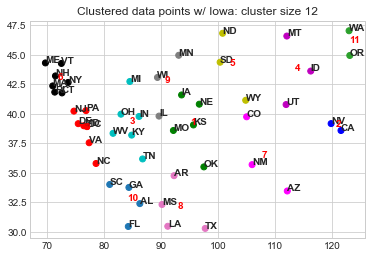

In [344]:
mod_locations = locations.copy() ## No Hawaii or Alaska in the location dictionary
mod_locations.pop('HI')
mod_locations.pop('AK')
labels, x, y = get_coordinates(mod_locations)
# Specify the number of clusters (3) and fit the data X
data_np = np.column_stack((x,y))

colormap = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'k',
                     'magenta', 'tab:pink', 'tab:gray', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange',
                    'paleturquoise', 'indianred', 'peru'])

for idx in [7,8,9,10,11,12]: ## These were examined to have possible good solutions, also balanced permutations size
    start = time.time()
    kmeans = KMeans(n_clusters=idx, random_state=0).fit(data_np)

    cluster = kmeans.labels_.tolist()
    # Plotting the cluster centers and the data points on a 2D plane
    plt.scatter(data_np[:, 0], data_np[:, -1], c=colormap[cluster])
    for i, txt in enumerate(labels):
        plt.annotate(txt, (float(x[i]), float(y[i])), weight='bold')
    for i in range(idx):
        plt.annotate(str(i), (kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]), c='red', weight='bold')

    plt.title('Clustered data points w/ Iowa: cluster size ' + str(idx))
    plt.show()
    
    state_organizer = organizer(labels, cluster, idx)
    cluster_center = kmeans.cluster_centers_.tolist()
    print(cluster_center)
    print(state_organizer)
    
    print(max([len(x) for x in state_organizer]))
    lengthOrganizer = [len(x) for x in state_organizer]
    for idx, state_set in enumerate(state_organizer):
        if 'IA' in state_set:
            start = idx ## Gets the start cluster number with Iowa
        if 'DC' in state_set:
            end = idx ## Gets the end cluster number with DC
    iterations = 0
    for idx, length in enumerate(lengthOrganizer):
        if idx == end:
            iterations += math.factorial(length - 2)
        else:
            iterations += math.factorial(length - 1)
    print(iterations)

    calc(state_organizer, cluster_center, idx)
    end = time.time()
    print(end - start)

In [336]:
output = {7:['IA', 'KS', 'OK', 'NE', 'MN', 'SD', 'ND', 'ID', 'WA', 'OR', 'CA', 'NV', 'UT', 'MT', 'WY', 'CO', 'NM', 'AZ', 'TX', 'AR', 'MS', 'LA', 'AL', 'FL', 'GA', 'TN', 'KY', 'IN', 'IL', 'MO', 'WI', 'MI', 'OH', 'NJ', 'CT', 'RI', 'MA', 'NH', 'ME', 'VT', 'NY', 'PA', 'DE', 'MD', 'VA', 'NC', 'WV', 'SC', 'DC'],
          8:['IA', 'MN', 'NE', 'KS', 'MO', 'AR', 'OK', 'TX', 'NM', 'AZ', 'CO', 'WY', 'UT', 'MT', 'ID', 'NV', 'CA', 'OR', 'WA', 'ND', 'SD', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'TN', 'MS', 'LA', 'AL', 'FL', 'GA', 'SC', 'CT', 'RI', 'MA', 'NH', 'ME', 'VT', 'NY', 'NJ', 'PA', 'DE', 'MD', 'VA', 'NC', 'WV', 'DC'],
          9:['IA', 'KS', 'NE', 'MN', 'SD', 'ND', 'MT', 'ID', 'UT', 'NV', 'CA', 'OR', 'WA', 'WY', 'CO', 'AZ', 'NM', 'OK', 'TX', 'AR', 'MS', 'LA', 'AL', 'FL', 'GA', 'SC', 'WV', 'OH', 'IN', 'KY', 'TN', 'MO', 'IL', 'WI', 'MI', 'NY', 'VT', 'ME', 'NH', 'MA', 'RI', 'CT', 'NJ', 'PA', 'DE', 'MD', 'VA', 'NC', 'DC'],
         10:['IA', 'MO', 'KS', 'NE', 'MN', 'SD', 'ND', 'MT', 'ID', 'UT', 'NV', 'CA', 'OR', 'WA', 'WY', 'CO', 'AZ', 'NM', 'OK', 'TX', 'LA', 'MS', 'AR', 'TN', 'GA', 'AL', 'FL', 'SC', 'KY', 'IN', 'IL', 'WI', 'MI', 'OH', 'NY', 'VT', 'ME', 'NH', 'MA', 'RI', 'CT', 'NJ', 'PA', 'DE', 'MD', 'VA', 'NC', 'WV', 'DC'],
         11:['IA', 'NE', 'KS', 'MO', 'IL', 'WI', 'MN', 'SD', 'ND', 'MT', 'UT', 'ID', 'OR', 'WA', 'NV', 'CA', 'AZ', 'NM', 'CO', 'WY', 'OK', 'TX', 'AR', 'MS', 'LA', 'AL', 'FL', 'SC', 'GA', 'TN', 'KY', 'IN', 'MI', 'OH', 'WV', 'NY', 'VT', 'ME', 'NH', 'MA', 'RI', 'CT', 'NJ', 'PA', 'DE', 'MD', 'VA', 'NC', 'DC'],
         12:['IA', 'NE', 'KS', 'OK', 'MO', 'IL', 'WI', 'MN', 'SD', 'ND', 'WY', 'UT', 'MT', 'ID', 'OR', 'WA', 'NV', 'CA', 'AZ', 'NM', 'CO', 'TX', 'AR', 'MS', 'LA', 'AL', 'FL', 'SC', 'GA', 'TN', 'KY', 'IN', 'MI', 'OH', 'WV', 'NY', 'VT', 'ME', 'NH', 'MA', 'RI', 'CT', 'NJ', 'PA', 'DE', 'MD', 'VA', 'NC', 'DC']}

optOptOrder = []
optOptDistance = float("inf")
optClusterNum = 0
for clusterNum, travel in output.items():
    start = time.time()
    order = travel
    oldMile = 0
    for idx, state in enumerate(order):
        if state != 'DC':
            oldMile += dist(state, order[idx + 1])
    print(order)
    print(clusterNum, oldMile)
    optOrder = []
    optDistance = float("inf")
    for idx1 in range(1,len(order)): ## HI
        newOrder = order[::]
        newOrder.insert(idx1, 'HI')
        for idx2 in range(1,len(order) + 1): ## AK
            newNewOrder = newOrder[::]
            newNewOrder.insert(idx2, 'AK')
            mile = 0
            for idx, state in enumerate(newNewOrder):
                if state != 'DC':
                    #print(dist(state, newNewOrder[idx + 1]), state, newNewOrder[idx + 1])
                    mile += dist(state, newNewOrder[idx + 1])
            if mile < optDistance:
                #print(mile)
                optOrder = newNewOrder
                optDistance = mile
    if optDistance < optOptDistance:
        optOptOrder = optOrder
        optOptDistance = optDistance
        optClusterNum = clusterNum
    print(clusterNum)
    print(optOrder)
    print(optDistance)
    end = time.time()
    print(end - start)
print("Spacing")
print(optClusterNum)
print(optOptOrder)
print(optOptDistance)

43.86478805541992
40.06000900268555
42.87173891067505
43.915852069854736
43.00497579574585
43.45019483566284
Spacing
11
['IA', 'NE', 'KS', 'MO', 'IL', 'WI', 'MN', 'SD', 'ND', 'MT', 'UT', 'ID', 'OR', 'WA', 'AK', 'HI', 'NV', 'CA', 'AZ', 'NM', 'CO', 'WY', 'OK', 'TX', 'AR', 'MS', 'LA', 'AL', 'FL', 'SC', 'GA', 'TN', 'KY', 'IN', 'MI', 'OH', 'WV', 'NY', 'VT', 'ME', 'NH', 'MA', 'RI', 'CT', 'NJ', 'PA', 'DE', 'MD', 'VA', 'NC', 'DC']
16905.85597768493


In [331]:
## Double Check length of output
print(len(optOptOrder))

51


In [337]:
### Times for Alaska and Hawaii iterations
ok = [43.86478805541992,
40.06000900268555,
42.87173891067505,
43.915852069854736,
43.00497579574585,
43.45019483566284]

print(sum(ok)/6)

42.86125977834066